# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [93]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from hyperspectral_image_generator import hyperspectral_image_generator
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
#COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
#if not os.path.exists(COCO_MODEL_PATH):
#    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [4]:
class SatsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "sats"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = SatsConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [5]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [17]:
image_path = '/data/spacenet/bldg/data/train/MUL/'
geojson_path = '/data/spacenet/bldg/data/train/geojson/'

In [89]:
class SatDataset(utils.Dataset):
    def scale_coord(self, geom, image):

        scale_x = abs(geom[0] - image.bounds[0]) * abs(image.width / (image.bounds[0] - image.bounds[2]))
        scale_y = abs(geom[1] - image.bounds[3]) * abs(image.height / (image.bounds[1] - image.bounds[3]))


        return scale_x, scale_y
    def preprocessing_image_ms(self, x, mean, std):
        # loop over image bands
        for idx, mean_value in enumerate(mean):
            x[..., idx] -= mean_value
            x[..., idx] /= std[idx]
        return x

    def load_sats(self, image_path, geojson_path):
        from glob import glob
        for i in range(1, 1000):
            self.add_class("sat", i, "building")
        
        image_glob = glob(image_path + '*.tif')
        for idx, path in enumerate(image_glob):
            self.add_image("sat", image_id=idx, path=path,
                          jsonPath=geojson_path)
    
    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        from skimage.io import imread
        # Load image
        input_path = self.image_info[image_id]['path']
        image = np.array(imread(input_path), dtype=float)
        
        bands = [4,2,1]
        
        image = image[:,:,bands]

        
        mean_std_data = np.loadtxt('image_mean_std.txt', delimiter=',')
        mean_std_data = mean_std_data[bands,:]
        image = self.preprocessing_image_ms(image, mean_std_data[:,0], mean_std_data[:,1])
        

        
        return image        
    
    def load_mask(self, image_id):
        import cv2
        import os
        import json
        import rasterio as rio
        import numpy as np
        import scipy.ndimage as ndi
        
        geojson_path = self.image_info[image_id]['jsonPath']
        input_path = self.image_info[image_id]['path']
        
        image_filename = os.path.split(input_path)[-1]
        json_filename = 'buildings' + image_filename[14:-4] + '.geojson'
        geojson_file = os.path.join(geojson_path, json_filename)
    
        #Load JSON
        with open(geojson_file, 'r') as f:
            geo_json = json.load(f)
    
        #Open image to get scale
        image = rio.open(input_path)
        image_shape = image.shape
        #Load and scale all the polygons (buildings)
        polys = []

        for feature in geo_json['features']:
            scaled_coordSet = []
            if feature['geometry']['type'] == 'Polygon':
                for coordinatesSet in feature['geometry']['coordinates']:
                    for coordinates in coordinatesSet:
                        scale_x, scale_y = self.scale_coord(coordinates, image)
                        scaled_coordSet += [[scale_x, scale_y]]

        
            if feature['geometry']['type'] == 'MultiPolygon':
                for polygon in feature['geometry']['coordinates']:
                    for coordinatesSet in polygon:
                        scaled_coord = []
                        for coordinates in coordinatesSet:
                            scale_x, scale_y = self.scale_coord(coordinates, image)
                            scaled_coord += [[scale_x, scale_y]]
                    scaled_coord = np.array(scaled_coord)
                scaled_coordSet += [scaled_coord]

            geom_fixed = np.array(scaled_coordSet, dtype=np.int32)
    
            if geom_fixed.shape[0] != 0:
                polys += [geom_fixed]
        
        polys = np.array(polys)

        mask = np.zeros(image_shape)
        cv2.fillPoly(mask, polys, 1)
    
        mask = mask.reshape(mask.shape[0], mask.shape[1])
        
        segs, count = ndi.label(mask)
        if count == 0:
            maskArr = np.empty([0, 0, 0])
            class_ids = np.empty([0], np.int32)
        else:
            maskArr = np.empty((segs.shape[0], segs.shape[1]))
            class_id_list = []
            for i in range(1, count+1):
                intArr = (segs == i)
                intArr.astype(int)
                maskArr = np.dstack((maskArr, intArr))
                class_id_list += [i]
            print(maskArr.shape)
            maskArr = np.delete(maskArr, 0, axis=2)
            
            class_ids = np.array(class_id_list)
        return maskArr, class_ids

In [90]:
# Training dataset
dataset_train = SatDataset()
dataset_train.load_sats(image_path, geojson_path)
dataset_train.prepare()

# Validation dataset
#dataset_val = ShapesDataset()
#dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
#dataset_val.prepare()

<ipython-input-89-9f31edcb8cb3>:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  polys = np.array(polys)


(650, 650, 19)


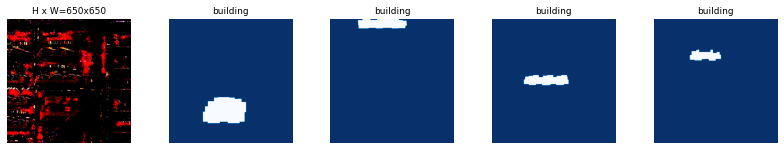

(650, 650, 5)


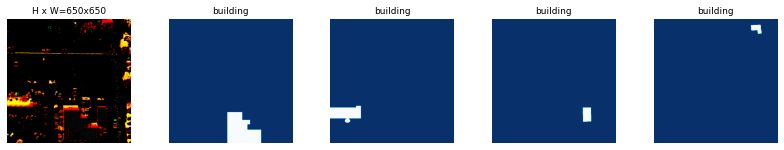

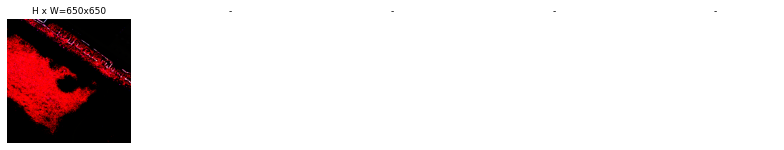

(650, 650, 5)


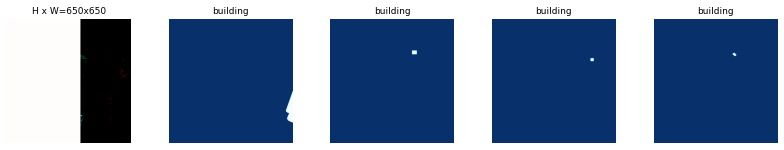

In [96]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [94]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

ValueError: 
The following Variables were created within a Lambda layer (anchors)
but are not tracked by said layer:
  <tf.Variable 'anchors/Variable:0' shape=(8, 4092, 4) dtype=float32>
The layer cannot safely ensure proper Variable reuse across multiple
calls, and consquently this behavior is disallowed for safety. Lambda
layers are not well suited to stateful computation; instead, writing a
subclassed Layer is the recommend way to define layers with
Variables.

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

## Detection

## Evaluation